### Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import Library

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input
from keras.applications.vgg16 import VGG16

warnings.filterwarnings('ignore')

### Import Dataset

In [ ]:
path = '/content/gdrive/MyDrive/AI Project/Corn Leaf Disease-Final/Train Final'
categories = os.listdir(path)
num_class = len(categories)

In [ ]:
categories

['Gray_Leaf_Spot', 'Common_Rust', 'Healthy', 'Blight']

In [ ]:
size = 100
batch_size = 64
epochs = 12

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(size,size),
    batch_size=batch_size,
    class_names=categories,
    label_mode='categorical',
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(size,size),
    batch_size=batch_size,
    class_names=categories,
    label_mode='categorical',
)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.
Found 4000 files belonging to 4 classes.
Using 800 files for validation.


### Visualisasi Gambar Pada Dataset

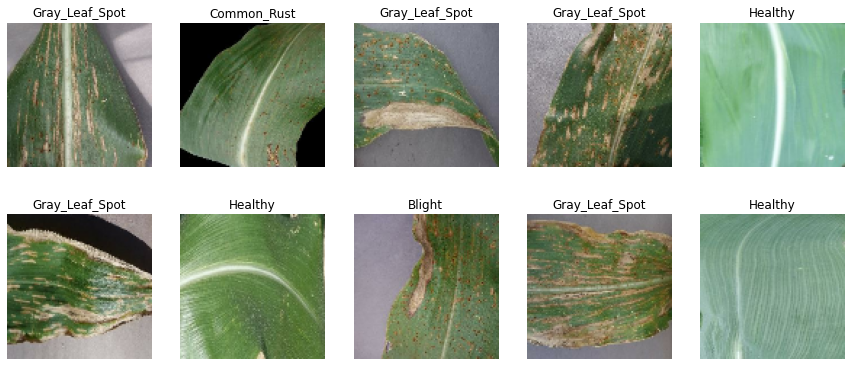

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(categories[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
for i in categories:
    directory = os.path.join(path, i)
    print("Images of label \"" + i + "\":\t", len(os.listdir(directory)))

Images of label "Gray_Leaf_Spot":	 1000
Images of label "Common_Rust":	 1000
Images of label "Healthy":	 1000
Images of label "Blight":	 1000


### Pretrained Model MobileNet V2


In [ ]:
base_model = VGG16(weights='/content/gdrive/MyDrive/AI Project/Corn Leaf Disease-Final/Model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
base_model.trainable = False

In [ ]:
from keras.optimizer_v2 import rmsprop, adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

def top_layer(base_model,neurons,act):
    checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/AI Project/Corn Leaf Disease-Final/Corn Leaf Disease_VGG16.h5", monitor="val_loss", save_best_only = True, verbose=1, mode = 'auto', save_freq = 'epoch')
    earlystop = EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1, mode = 'auto')

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(neurons*3, activation=act)(x)
    x = Dropout(0.1)(x)
    x = Dense(neurons, activation=act)(x)
    x = Dropout(0.1)(x)
    x = Dense(neurons*2, activation=act)(x)
    x = Dropout(0.1)(x)
    x = Dense(neurons*1, activation=act)(x)
    x = Dropout(0.1)(x)
    x = Dense(neurons/2, activation=act)(x)
    x = Dropout(0.1)(x)

    predictions = Dense(num_class, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    callbacks = [earlystop, checkpoint]
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()


    history= model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks = callbacks)

    return  history,model


In [ ]:
history1,model1=top_layer(base_model,512,"relu")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
score1= model1.evaluate(train_ds, verbose=0)
val_score1= model1.evaluate(val_ds, verbose=0)
print('Test Loss:', val_score1[0])
print('Test Accuracy:', val_score1[1])

Test Loss: 0.3935357928276062
Test Accuracy: 0.9225000143051147


In [ ]:
m1_accu = score1[1]
m1_accu_val =  val_score1[1]

In [ ]:
s = pd.DataFrame({"Model":["VGG 16"],"Test":[m1_accu],"Validation":[m1_accu_val]})
tableMk=s.to_markdown(tablefmt="grid")

In [ ]:
print(tableMk)

+----+---------+----------+--------------+
|    | Model   |     Test |   Validation |
+====+=========+==========+==============+
|  0 | VGG 16  | 0.992813 |       0.9225 |
+----+---------+----------+--------------+


### Visualisasi Accuracy dan Loss

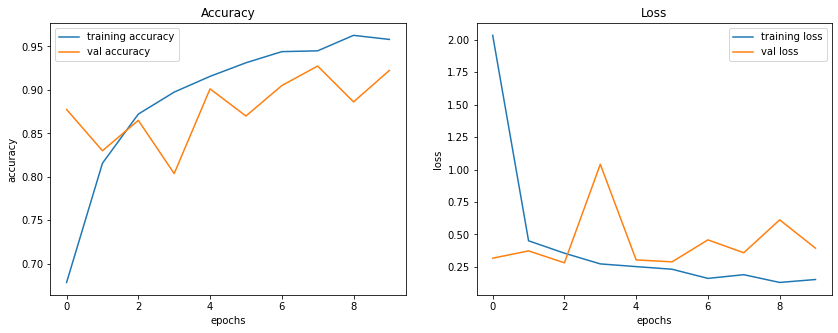

In [ ]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(history1.history ['accuracy'], label='training accuracy')
plt.plot(history1.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(history1.history['loss'], label='training loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
val_samples = sum([y.shape[0] for [_, y] in val_ds])
val_samples

800

In [ ]:
def pred(model):
    y_val = []
    y_val_pred = []
    for images, targets in val_ds:
        for image, target in zip(images, targets):
            img_array = image.numpy().astype("uint8")
            prediction = model.predict(np.array([img_array]))
            y_val_pred.append(np.argmax(prediction))
            y_val.append(np.argmax(target))

    return y_val, y_val_pred

In [ ]:
import plotly.express as px
from sklearn.metrics import confusion_matrix

def print_cf(model):
    y_val, y_val_pred=pred(model)
    cm = confusion_matrix(y_val, y_val_pred,normalize='true')
    fig = px.imshow(cm, labels=dict(x="Predicted", y="Real"), x=categories,y=categories)
    fig.update_xaxes(side="top")
    fig.show()

In [ ]:
print_cf(model1)

#### Hasil Prediksi Model VGG16

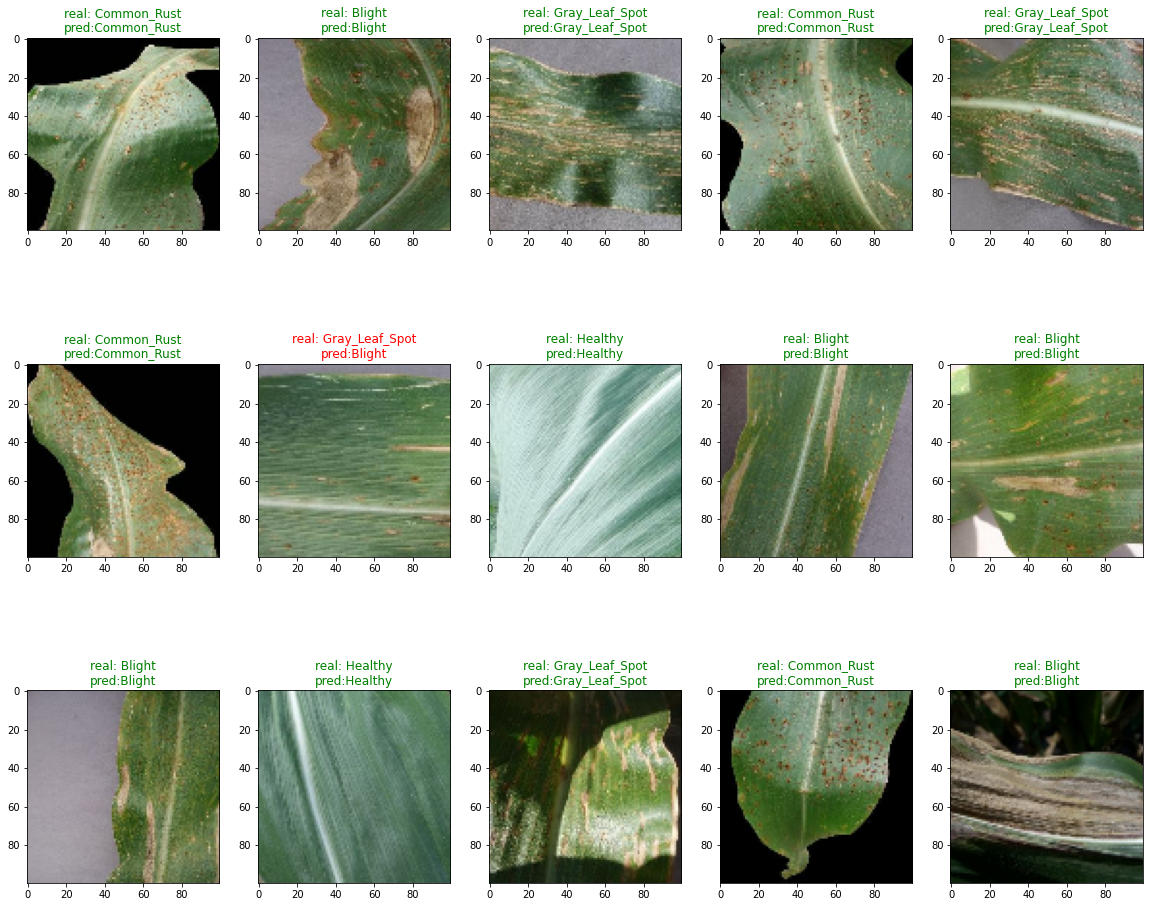

In [ ]:
plt.figure(figsize=(20, 17))
for images, labels in val_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)

        img_array = images[i].numpy().astype("uint8")
        prediction = model1.predict(np.array([img_array]))
        prediction_name = categories[np.argmax(prediction)]
        real_name = categories[np.argmax(labels[i])]

        plt.imshow(img_array)
        if prediction_name == real_name:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'g'})
        else:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'r'})

Saving Corn_Blight (954).JPG to Corn_Blight (954).JPG
Corn_Blight (954).JPG
Common_Rust


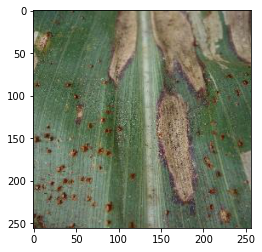

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256,256))
  model_vgg16 = load_model('/content/gdrive/MyDrive/AI Project/Corn Leaf Disease-Final/Corn Leaf Disease_VGG16.h5')

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model_vgg16.predict(images, batch_size=10)
  print(fn)
  if classes[0][0] == 0:
   print('Gray_Leaf_Spot')
  elif classes[0][1] !=0:
    print('Common_Rust')
  elif classes[0][2] !=0:
    print('Healthy')
  else:
   print('Blight')

99.99927282333374% Confidence It's a leaf with disease Common Rust


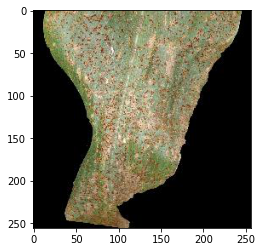

In [ ]:
from matplotlib.pyplot import imshow
from tensorflow.keras.models import load_model
from PIL import Image

def names(number):
    if number==0:
        return "It's a leaf with disease BLIGHT"
    elif number==1:
        return "It's a leaf with disease Common Rust"
    elif number==2:
        return "It's a leaf with disease Gray_Leaf_Spot"
    elif number==3:
        return "It's a Healthy leaf"

model_vgg16 = load_model('/content/gdrive/MyDrive/AI Project/Corn Leaf Disease-Final/Corn Leaf Disease_VGG16.h5')

img = Image.open(r"/content/gdrive/MyDrive/AI Project/Corn Leaf Disease-Final/Test Final/Common_Rust/Corn_Common_Rust (1058).JPG")
x = np.array(img.resize((224,224)))
x = x.reshape(1,224,224,3)
res = model_vgg16.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence ' + names(classification))